# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline
plt.style.use('seaborn')

/var/folders/jd/w7l6z0gx57sfmxp1l3n6bfkw0000gn/T/ipykernel_5249/2450847266.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Итак, прочитаем нашу таблицу:

In [3]:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

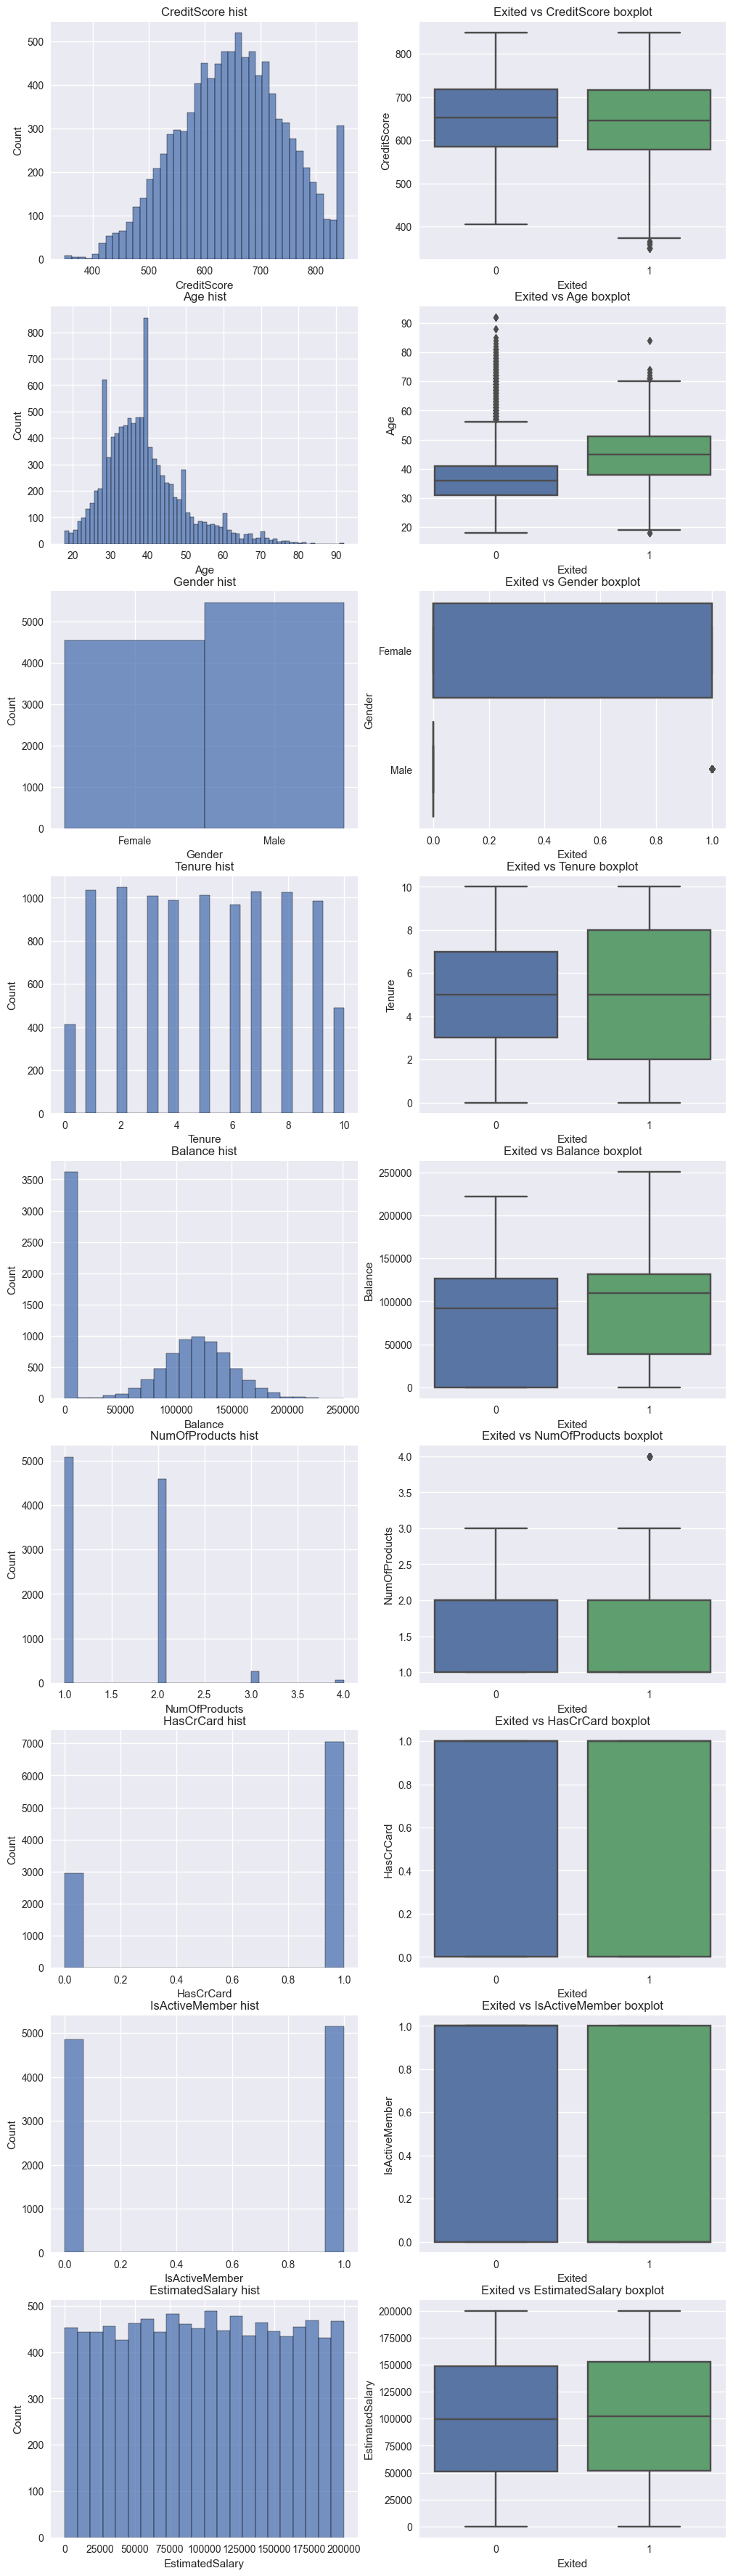

In [4]:
# Ваш код здесь
# Lets build histogram and boxplot for every revelant feature

# creating list with column names
features = list(churn_data[['CreditScore', 'Age', 'Gender', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']].columns)

# length of the list, will use to place each chart correctly on the plot
n = len(features)

# initialize plot
fig, ax = plt.subplots(n, 2, figsize=(12, 45))

# iterate through features list and plot every feature in appropriate ax
for i, feature in enumerate(features):
    hist = sns.histplot(data=churn_data, x=churn_data[feature], ax=ax[i][0])
    ax[i][0].set_title('{} hist'.format(feature))
    
    boxplot = sns.boxplot(data=churn_data, x=churn_data['Exited'], y=churn_data[feature], ax=ax[i][1])
    ax[i][1].set_title('Exited vs {} boxplot'.format(feature))
    

<Axes: >

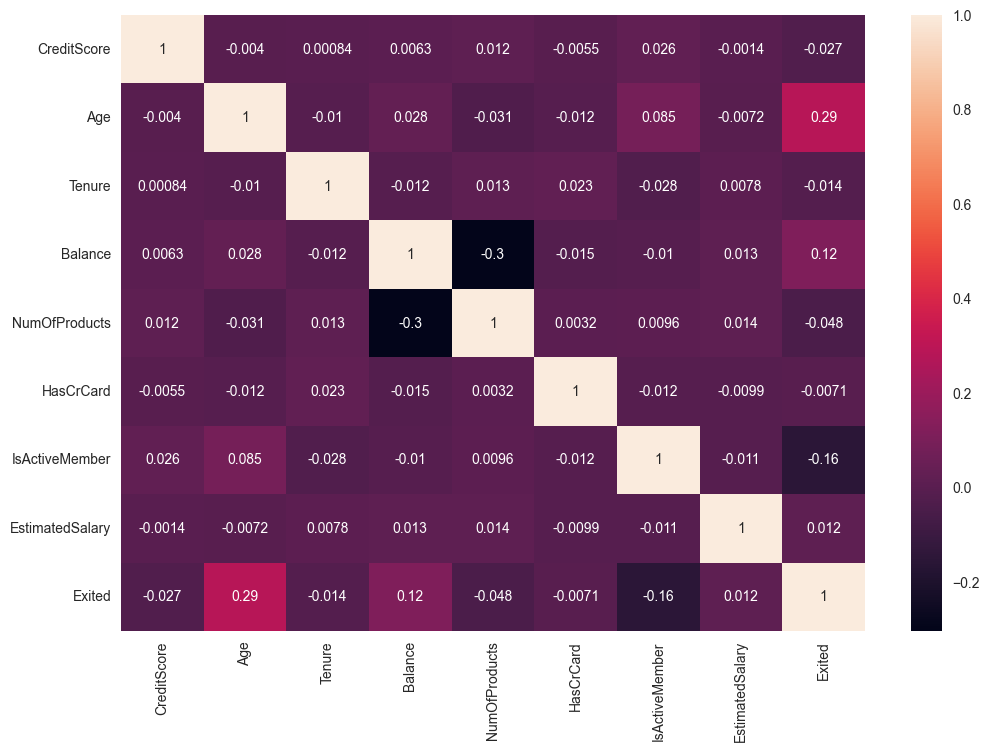

In [5]:
# Build a correlation matrix for numerical features

# list with the columns names for numerical features
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
# initialize the plot
fig= plt.figure(figsize=(12, 8))
# build correlation matrix
sns.heatmap(churn_data[num_features].corr(), annot=True)

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [6]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [7]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [8]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [9]:
churn_data[churn_data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [10]:
# Ваш код здесь

# creating new future BalanceSalaryRatio
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']

# creating new future TenureByAge
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']

# creating new feature CreditScoreGivenAge
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

# encoding feature Gender to Binary, 1 - Female, 0 - Male
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Female' else 0)

# displaying statistical characterestics of data set
churn_data.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,0.475488,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487
std,98.168937,0.499498,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558
min,350.000000,0.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676
25%,584.000000,0.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275
50%,651.000000,0.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143
75%,722.000000,1.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941
max,850.000000,1.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [11]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [12]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [13]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [14]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [15]:
# Ваш код здесь

# creating object for Standard Scaler
scaler = preprocessing.StandardScaler()

# calculating parameters min and max for each column
scaler.fit(X_train)

# normalizing X_train and X_test data sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Укажите название метрики и обоснования своего выбора здесь:

**F1 score: balance between Precision and Recall. Combines both metrics into a single one**

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Ваши рассуждения и ответ — *здесь*.

The F1 score is the harmonic mean of Precision and Recall, which are both critical in scenarios with limited resources. High Precision reduces False Positives, ensuring that the model only flags customers who are most likely to churn, whereas high Recall ensures that the model identifies as many actual churn cases as possible. Since these two metrics can often move inversely to each other — improving one may worsen the other — the F1 score is valuable as it balances the two, providing a single measure of the model's accuracy in identifying true churn cases without excessively targeting unlikely ones.

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [16]:
# Ваш код здесь
# initialize object of Logistic Regression class
logistic_reg = linear_model.LogisticRegression(random_state=42, max_iter=5000)

# teach the model
logistic_reg.fit(X_train_scaled, y_train)
# predicting values of X_train_scaled and X_test_scaled
y_train_predict = logistic_reg.predict(X_train_scaled)
y_test_predict = logistic_reg.predict(X_test_scaled)

# Lets evaluate our model prediction using F1 score metric
# for train data set
print('F1 metric for Train data set: ',metrics.f1_score(y_train, y_train_predict))
print('\n')
# for test data set
print('F1 metric for Test data set: ', metrics.f1_score(y_test, y_test_predict))

F1 metric for Train data set:  0.5121241513094082


F1 metric for Test data set:  0.4942528735632184


> Ваши выводы и рассуждения — *здесь*.

The close F1 scores between the train and test datasets suggest that the model is generalizing well and is not overfitting. However, the moderate F1 scores indicate there is room for improvement. Experimenting with different values of the C parameter has been conducted and no significant improvement in the metric scores has been observed. This might be due to the model already operating at its best given the current features or possibly because of other factors, such as complex relationships not captured by the model or the presence of outliers in the data. We used 'lbfgs' solver, and only L2 regularization is applicable, no significant change was observed. Given the potential complexity of the dataset, considering polynomial features or other forms of feature engineering could help improve the model's performance.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [17]:
# Ваш код здесь
# initialize the instance of the PolynomialFeatures class with degree=3
# include_bias=False means the output will not include column for intercept (bias) term
poly_features = preprocessing.PolynomialFeatures(degree=3, include_bias=False)

# Fit PolynomialFeatures model on X_train_scaled data
# This step computes neccesary number of polynomial combinations from the provided features
poly_features.fit(X_train_scaled)

# Transform X_train_scaled data into its polynomial features representation
# This creates new features that are all polynomial combinations of original features up to a 3rd degree
X_train_poly = poly_features.transform(X_train_scaled)

# Similiarly, transform X_test_scaled to its polynomial features representation.
# This creates new features that are polynomial combination of the original features up to a 3rd degree, and ensures that test data is expanding in the same way as train data
X_test_poly = poly_features.transform(X_test_scaled)



# create the instance of LogisticRegression class with random_state=42
logistic_poly_reg = linear_model.LogisticRegression(random_state=42, max_iter=10000, C=0.05, penalty='l2')

# Fit LogisticRegression on X_train_poly data with polynomial features and the correct answers of y_train data
logistic_poly_reg.fit(X_train_poly, y_train)

# Predict class for X_train_poly and X_test_poly
y_train_poly_predict = logistic_poly_reg.predict(X_train_poly)
y_test_poly_predict = logistic_poly_reg.predict(X_test_poly)

# Lets evaluate our model prediction using F1 score metric
# for train data set
print('F1 metric for Train data with Polynomial features: ',metrics.f1_score(y_train, y_train_poly_predict))
print('\n')
# for test data set
print('F1 metric for Test data with Polynomial features: ', metrics.f1_score(y_test, y_test_poly_predict))

F1 metric for Train data with Polynomial features:  0.7568523430592397


F1 metric for Test data with Polynomial features:  0.6613333333333333


> Ваши выводы и рассуждения — *здесь*

The implementation of polynomial features has improved the model's ability to predict customer churn, as evidenced by the increased F1 score for the training dataset. Adjusting the C parameter to 0.05, which is less than the default value of 1, has applied a stronger regularization penalty to the model. This change seems to have contributed to a better fit on the training data and a decent generalization on the test data, as the F1 score for the test dataset has also shown improvement, though it is lower than the training score, suggesting some overfitting.

The conclusion we can draw is that incorporating polynomial features allowed the logistic regression model to capture more complex relationships in the data, which was not possible with linear features alone. Furthermore, tuning the regularization strength by decreasing the C value has likely helped the model to achieve a balance between fitting the training data and maintaining the ability to generalize to new, unseen data. It's worth noting that while the stronger regularization helped in this scenario, there's a trade-off between bias and variance that needs to be carefully managed. Too much regularization can lead to underfitting, where the model is too simple to capture the underlying trends.

In summary, the integration of polynomial features and the tuning of the C parameter have proven beneficial for the predictive performance of the model in this case

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

The threshold value that give highest F1 score for Test data:  0.3500000000000001
F1 metric for Train data with Polynomial features:  0.7560975609756098
F1 metric for Test data with Polynomial features:  0.672686230248307


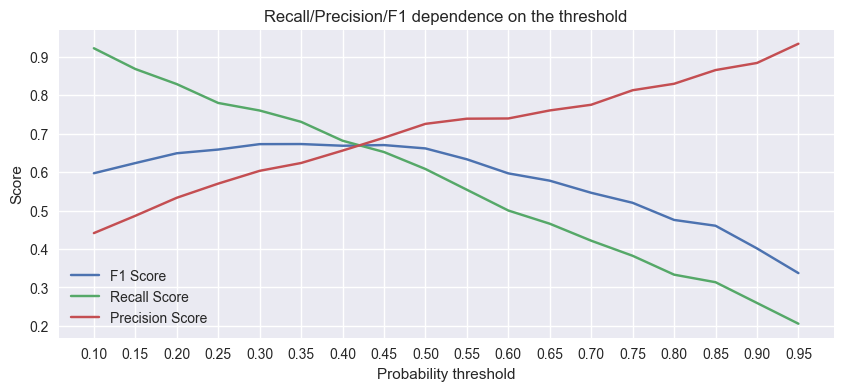

In [18]:
# Making a prediction of the churn probability for each client in the test sample
y_test_proba_pred = pd.Series(logistic_poly_reg.predict_proba(X_test_poly)[:, 1])

# Initialize lists where we will store the values of metrics
f1_scores = []
recall_scores = []
precision_scores = []


# Define probability thresholds
thresholds = np.arange(0.1, 1, 0.05)
# Iterate over the values of probability thresholds in a loop
for threshold in thresholds:
    # Make predictions based on the current threshold
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Calculate the metric (F1 Score)
    f1_score = metrics.f1_score(y_test, y_test_pred_poly)
    # Calculate the metric (Recall Score)
    recall_score = metrics.recall_score(y_test, y_test_pred_poly)
    # Calculate the metric (Precision Score)
    precision_score = metrics.precision_score(y_test, y_test_pred_poly)
    # Add the result to the list
    f1_scores.append(f1_score)
    recall_scores.append(recall_score)
    precision_scores.append(precision_score)
   
    
# Create a figure and a set of subplots with a specific size
fig, ax = plt.subplots(figsize=(10, 4))

# Plot the scores for each threshold
ax.plot(thresholds, f1_scores, label='F1 Score')
ax.plot(thresholds, recall_scores, label='Recall Score')
ax.plot(thresholds, precision_scores, label='Precision Score')

# Set the title of the plot
ax.set_title('Recall/Precision/F1 dependence on the threshold')
# Set the label for the x-axis
ax.set_xlabel('Probability threshold')
# Set the label for the y-axis
ax.set_ylabel('Score')

# Set the ticks on the x-axis to correspond to the defined thresholds
ax.set_xticks(thresholds) 
# Display the legend on the plot
ax.legend();

# index of the largest value in f1_score list
index_of_max_f1 = f1_scores.index(max(f1_scores))
# the threshold value that give the highest F1 score mertric value
best_threshold = list(thresholds)[index_of_max_f1]
print('The threshold value that give highest F1 score for Test data: ', best_threshold)
#----------------Running model with threshold set to best_threshold----------------------#
y_train_proba_predict = pd.Series(logistic_poly_reg.predict_proba(X_train_poly)[:, 1])
y_test_proba_predict = pd.Series(logistic_poly_reg.predict_proba(X_test_poly)[:, 1])

y_train_predict = y_train_proba_predict.apply(lambda x: 1 if x > best_threshold else 0)
y_test_predict = y_test_proba_predict.apply(lambda x: 1 if x > best_threshold else 0)


# Lets evaluate our model prediction using F1 score metric
# for train data set
print('F1 metric for Train data with Polynomial features: ',metrics.f1_score(y_train, y_train_predict))
# for test data set
print('F1 metric for Test data with Polynomial features: ', metrics.f1_score(y_test, y_test_predict))

#### Conclusions

In conclusion, the analysis has been conducted by utilizing a logistic regression model with polynomial features to predict customer churn. The model's performance has been evaluated across various probability thresholds ranging from 0.1 to 0.95, with an increment of 0.05, to find the best trade-off between precision and recall for classification decisions.

Based on the plotted evaluation metrics (F1 Score, Recall Score, Precision Score) against different thresholds, it’s observed that the F1 score is maximized at a threshold of approximately 0.35. At this threshold, the F1 score reaches its peak, representing the best harmonic mean of precision and recall obtained by the model.

The chosen threshold of 0.35 indicates that customers with a predicted churn probability higher than 0.35 are classified as likely to churn, allowing for a more sensitive detection of potential churn cases. This might be especially useful considering limited resources and the objective to effectively identify and retain customers at risk of churning.

It's essential to mention that hyperparameter tuning, specifically adjusting the C parameter, has been conducted to control the regularization strength, optimizing the model's performance. Various C values were explored, with C=0.05 yielding the most satisfactory results in terms of the F1 score.

Moving forward, it might be beneficial to explore additional feature engineering techniques and handle outliers to enhance model performance further.

In summary, the model, with polynomial features and a carefully chosen threshold and regularization parameter, provides a thoughtful approach to identifying customers likely to churn, supporting efficient resource allocation for customer retention efforts.

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [19]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [20]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [22]:
# Ваш код здесь
# initiliaze the instance of DTC class, with criterion set to 'entropy'
dt = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)

# Fit the Decision Tree model on X_train and y_train data
dt.fit(X_train, y_train)

# make predictions for X_train and X_test data
y_train_predict = dt.predict(X_train)
y_test_predict = dt.predict(X_test)

# evaluate predictions using F1 score and print them
# for Train data
print('The F1 metric score for Train data: {}'.format(metrics.f1_score(y_train, y_train_predict)))
# for Test data
print('The F1 metric score for Test data: {}'.format(metrics.f1_score(y_test, y_test_predict)))


The F1 metric score for Train data: 1.0
The F1 metric score for Test data: 0.5599999999999999


> Ваши выводы и рассуждения — *здесь*

The model exhibits a clear sign of overfitting, as it performs perfectly on the training data with an F1 score of 1.0, but significantly worse on the test data with an F1 score of 0.56. This discrepancy in performance is due to the decision tree being overly complex, as the parameters max_depth and min_samples_leaf were not set, allowing the model to grow without restrictions. As a result, the decision tree has probably learned the training data by heart, fitting to noise and outliers, rather than learning the underlying patterns. This has led to a model that is not generalizable to new, unseen data, as evidenced by the lower F1 score on the test set. To improve the model, we could consider adding constraints like setting a max depth or minimum samples leaf to prevent the model from fitting too closely to the training data.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [23]:
# Ваш код здесь
# initiliaze the instance of DTC class, with criterion set to 'entropy', max tree depth to 8, and minimum samples per leaf set to 10
dt_controlled = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=8, min_samples_leaf=10)

# Fit the Decision Tree model on X_train and y_train data
dt_controlled.fit(X_train, y_train)

# make predictions for X_train and X_test data
y_train_predict = dt_controlled.predict(X_train)
y_test_predict = dt_controlled.predict(X_test)

# evaluate predictions using F1 score and print them
# for Train data
print('The F1 metric score for Train data: {}'.format(metrics.f1_score(y_train, y_train_predict)))
# for Test data
print('The F1 metric score for Test data: {}'.format(metrics.f1_score(y_test, y_test_predict)))

The F1 metric score for Train data: 0.7172538392050587
The F1 metric score for Test data: 0.6397849462365591


> Ваши выводы и рассуждения — *здесь*

In this iteration, by constraining the Decision Tree Classifier (DTC) using parameters such as the maximum tree depth and minimum samples per leaf, the model's tendency to overfit has been curtailed. Parameters like max_depth=8 and min_samples_leaf=10 prevent the tree from growing too complex, helping it to generalize better to unseen data.

The resulting F1 scores showcase the effectiveness of these constraints. The model achieves an F1 score of approximately 0.717 on the training data and 0.640 on the test data. The smaller gap between these scores, compared to the previous iteration, indicates a reduction in overfitting.

These scores suggest that the model, while still slightly overfitting, is now better at capturing the underlying patterns in the data without fitting too closely to the noise or outliers present in the training set. The improved test F1 score further confirms that our model's generalization capability has been enhanced by controlling its complexity.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [24]:
# Ваш код здесь
# initialize the instance of the class RandomForestClassifier
# set the maximum number of trees to n_estimators=500, max tree depth to max_depth=8, criteration to criteration='entropy'
# and minimum samples per leaf to min_samples_leaf=10
rf_cf = ensemble.RandomForestClassifier(n_estimators=500, max_depth=8, criterion='entropy', min_samples_leaf=10, random_state=42)

# fit Random Forest Classifier into X_train, y_train
rf_cf.fit(X_train, y_train)

# make predictions to Train and Test data
y_train_predict = rf_cf.predict(X_train)
y_test_predict = rf_cf.predict(X_test)

# evaluate the models using F1 metric score
print('The F1 score for Train data using RandomForestClassifier model: {}'.format(metrics.f1_score(y_train, y_train_predict)))
print('The F1 score for Test data using RandomForestClassifier model: {}'.format(metrics.f1_score(y_test, y_test_predict)))

The F1 score for Train data using RandomForestClassifier model: 0.7350746268656716
The F1 score for Test data using RandomForestClassifier model: 0.6556473829201102


> Ваши выводы и рассуждения — *здесь*

Utilizing the Random Forest Classifier (RFC) model has enhanced our predictive performance, yielding improved F1 scores for both the training and test datasets compared to the Decision Tree Classifier (DTC) model. The RFC model achieved an F1 score of approximately 0.735 on the training data and 0.656 on the test data.

A notable observation is the reduced overfitting in the RFC model compared to the DTC model. This is evident from the smaller discrepancy between the F1 scores on the training and test datasets, making the RFC model more generalizable to new, unseen data.

The enhanced performance of the RFC model can be attributed to its ensemble nature. RFC, unlike DTC, constructs multiple decision trees during training, each being built on a bootstrapped sample of the data (samples drawn randomly with replacement). For predictions, the RFC model considers the output of all the individual trees, opting for a majority voting approach. This ensemble method inherently brings robustness and diversity, leading to improved accuracy and reduced overfitting.

In conclusion, the Random Forest Classifier, with its ensemble approach, has demonstrated superior performance in terms of the F1 score and robustness compared to a single Decision Tree Classifier in predicting customer churn.
 

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

The F1 score for Train data using RFC model with probablity threshold set to 0.35: 0.7661227661227662
The F1 score for Test data using RFC model with probablity threshold set to 0.35: 0.6991150442477877


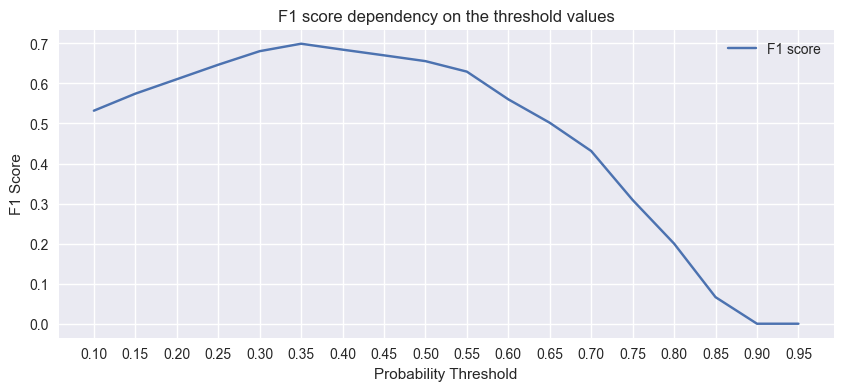

In [56]:
# Ваш код здесь

# return evenly spaced values within given interval
thresholds = np.arange(0.1, 1, 0.05)

# creating predictions for each bank client to churn
y_test_predict_proba = pd.Series(rf_cf.predict_proba(X_test)[:, 1])

# creating list to save F1 score for each threshold
f1_scores = []

# iterate through each threshold value and evaluate F1 score metric with this threshold value
for threshold in thresholds:
    y_test_predict = y_test_predict_proba.apply(lambda x: 1 if x > threshold else 0)
    
    # evaluate the F1 metric score and add it to the list f1_scores
    score = metrics.f1_score(y_test, y_test_predict)
    f1_scores.append(score)

# Plot the diagramm, thresholds vs F1 scores
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(thresholds, f1_scores, label='F1 score')
ax.set_title('F1 score dependency on the threshold values')
ax.set_ylabel('F1 Score')
ax.set_xlabel('Probability Threshold')
ax.set_xticks(thresholds)

# Display the legend on the plot
ax.legend();


# We can see from the plot below that highest F1 score value is at probablity level of 0.35
# Lets make prediction using threshold 0.35 and compare metrics for Train and Test data
y_train_predict = pd.Series(rf_cf.predict_proba(X_train)[:, 1]).apply(lambda x: 1 if x > 0.35 else 0)
y_test_predict = pd.Series(rf_cf.predict_proba(X_test)[:, 1]).apply(lambda x: 1 if x > 0.35 else 0)

print('The F1 score for Train data using RFC model with probablity threshold set to 0.35: {}'.format(metrics.f1_score(y_train, y_train_predict)))
print('The F1 score for Test data using RFC model with probablity threshold set to 0.35: {}'.format(metrics.f1_score(y_test, y_test_predict)))

> Ваши выводы и рассуждения — *здесь*

Through iterating over various probability thresholds, an optimal threshold was sought to maximize the F1 score of the model on both the training and test datasets. This iterative process is instrumental in fine-tuning the model's performance, as it allows for the adjustment of classification decision boundaries, ensuring that the model's predictions are aligned as closely as possible with the actual outcomes.

In this case, a probability threshold of 0.35 was identified as optimal, yielding the highest F1 scores for both datasets — approximately 0.766 for the training data and 0.699 for the test data. This underscores the significance of selecting an appropriate threshold in enhancing the model’s predictive accuracy, demonstrating the value of this approach in model optimization.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [75]:
# Ваш код здесь

# create data frame
vasiliy_df = pd.DataFrame(
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# lets convert the 'Gender' column from categorical to numerical
# In our previous data, we used 1-Female and 0-Male
vasiliy_df['Gender'] = 0

# Our model was teached on the data that had additional features 'BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge'
# Lets add this features to our vasiliy_df
# creating new future BalanceSalaryRatio
vasiliy_df['BalanceSalaryRatio'] = vasiliy_df['Balance'] / vasiliy_df['EstimatedSalary']

# creating new future TenureByAge
vasiliy_df['TenureByAge'] = vasiliy_df['Tenure'] / vasiliy_df['Age']

# creating new feature CreditScoreGivenAge
vasiliy_df['CreditScoreGivenAge'] = vasiliy_df['CreditScore'] / vasiliy_df['Age']

print('What is the probablity of customer Vasiliy to churn?: {}%'.format(round(rf_cf.predict_proba(vasiliy_df)[:, 1][0] * 100, 2)))

# the customer has a 62.3% probablity to churn

What is the probablity of customer Vasiliy to churn?: 62.29%
